# **给 Colab 用户的注意事项**

# **不要直接在此文件中编辑——你的内容可能会丢失！**

# **开始之前请务必先复制一份。**

如何复制文件

1. 点击左上角的“File”。
> *如果找不到菜单栏（比如“File”或“Runtime”），点击右上角的“v”标记展开菜单。*

2. 选择“Save a copy in Drive”

3. 把复制的文件名改成 “YOURNAMEs\_FileName.ipynb”。
> 例如：如果你叫 Olivia，就改成 Olivias_FileName.ipynb



---

* 选中的对号（✅）不会被保存。用 Chrome 的刷新按钮重载页面时，这些标记会消失。<br>
如果你想暂停后续做，自己加个文本单元写上“SO FAR DONE”等字样即可。

---

* 在 Colab 里，**之前的输出会每隔 30 到 90 分钟重置一次**。<br>
所以经常会出现 `~~ is not defined` 这类错误。

  🔁 遇到 `~~ is not defined` 错误怎么办？
  1. 先确认变量拼写无误。<br>
  2. 拼写没问题但仍报错，**点击你想重新运行的单元格**。<br>
  3. 点击左上角的“Runtime” → 选择“Run before”。<br>
    → 这会**重新运行之前的所有单元格**。
  4. 再运行该单元格。

  如果按照以上步骤还是报错，<br>
大概率是之前单元中的 TODO 答案有根本性错误。<br>
请检查答案是否正确，<br>
或者请教 ChatGPT 或其他编程助手帮你。

# **Preparation**

本节仅加载之前章节的内容。<br>
只需运行代码即可，无需阅读。<br>
可以随意跳过。<br>

In [ ]:
# 下载文件
!wget https://raw.githubusercontent.com/HayatoHongo/Everyones_nanoGPT/main/input.txt -O input.txt
# 加载刚下载的名为 input.text 的文件，编码为 utf-8。
with open("input.txt", 'r', encoding = 'utf-8') as f:
    text = f.read()

# 一个用于美观显示张量的函数（可跳过）
import torch
import torch.nn as nn
import torch.nn.functional as F

def print_formatted_tensor(*args, width=6, decimals=2):
    """
    A function that neatly formats and displays a PyTorch Tensor, and also prints its size.

    Example usage:
        print_formatted_tensor("name", tensor)
        print_formatted_tensor(tensor)

    Args:
        *args: If given 1 argument, it is treated as a tensor.
               If given 2 arguments, the first is treated as the name, the second as the tensor.
        width (int): Display width for each number (default: 6)
        decimals (int): Number of decimal places to show (default: 2)
    """

    # Determine tensor and name from arguments
    if not args:
        raise ValueError("At least one argument is required.")
    if isinstance(args[0], str):
        if len(args) < 2:
            raise ValueError("Tensor is not specified.")
        name, tensor = args[0], args[1]
    else:
        name, tensor = None, args[0]

    # Convert Tensor to List
    tensor_list = tensor.detach().cpu().tolist()

    def format_list(lst, indent):
        """Formatting a recursively nested list and returning a string"""
        # If the contents are lists, then re-return
        if isinstance(lst, list) and lst and isinstance(lst[0], list):
            inner = ",\n".join(" " * indent + format_list(sub, indent + 2) for sub in lst)
            return "[\n" + inner + "\n" + " " * (indent - 2) + "]"
        # For numerical lists
        return "[" + ", ".join(f"{v:{width}.{decimals}f}" for v in lst) + "]"

    # Formatted string (bar brackets on outermost frames are removed)
    formatted = format_list(tensor_list, indent=9)
    inner_formatted = formatted[1:-1].strip()

    # Result output
    if name:
        print(name)
    print(f"Tensor Size: {list(tensor.size())}")
    print("tensor([")
    print(" " * 9 + inner_formatted)
    print(" " * 7 + "])")

--2025-07-08 11:25:56--  https://raw.githubusercontent.com/HayatoHongo/nanoGPT_todo/main/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.03s   

2025-07-08 11:25:56 (31.2 MB/s) - ‘input.txt’ saved [1115394/1115394]



# **Chapter 12 Trainer Class**

### **Section 1: Class Definition**

🔘 **Options**：可能会有一些你用不到的额外选项。

`self.model`　`self.optimizer`　`self.data_loader`　`self.config`　`split_data`　`get_batch`　`'train'`、`'val'`　`input_batch`　`target_batch`　`logits`　`self.config.total_training_steps`　`self.config.evaluation_loops`  
`loss`　`backward()`　`self.train_step()`　`self.evaluate()`

In [ ]:
class Trainer:
    def __init__(self, model, optimizer, data_loader, config):
        self.model = model
        self.optimizer = optimizer
        self.data_loader = data_loader
        self.config = config

    def train_step(self):
        # 获取一批用于训练的数据。
        input_batch, target_batch = self.data_loader.get_batch('train')
        self.optimizer.zero_grad()

        # 模型前向传播和损失计算
        logits, loss = self.model(input_batch, target_batch)
        loss.backward()  # 反向传播（误差反向传播）
        self.optimizer.step()  # 更新参数

        return loss.item() # 返回损失值

    def evaluate(self):
        self.model.eval()  # 设置为评估模式
        losses = {"train": [], "val": []} # 计算训练和验证数据的损失
        with torch.no_grad():
            for split in ['train', 'val']:
                for _ in range(self.config.evaluation_loops):
                    input_batch, target_batch = self.data_loader.get_batch(split)
                    _, loss = self.model(input_batch, target_batch)
                    losses[split].append(loss.item())
        self.model.train()  # 返回训练模式

        # 计算每个拆分（训练集、验证集）的平均损失
        return {split: sum(values) / len(values) for split, values in losses.items()}

    def train(self):
        # 根据配置中指定的次数运行 train_step。
        for step in range(self.config.total_training_steps):

            # 每隔100次迭代或仅在最后一步进行评估。
            if step % self.config.evaluation_frequency == 0 or step == self.config.total_training_steps - 1:
                eval_loss = self.evaluate()
                print(f"Step {step}: Train Loss {eval_loss['train']:.4f}, Validation Loss {eval_loss['val']:.4f}")

            # 训练的一步（每次执行的主要过程）
            train_loss = self.train_step()

In [ ]:
"""
将英文注释、文档字符串和 print 语句简洁、友好、自然地翻译成简体中文。
class Trainer:
    def __init__(self, model, optimizer, data_loader, config):
        self.model = model
        self.optimizer = optimizer
        self.data_loader = data_loader
        self.config = config

    def train_step(self):
        # 获取一批用于训练的数据。
        input_batch, target_batch = ___________._______(_____)
        self.optimizer.zero_grad()

        # 模型前向传递和损失计算
        logits, loss = _______(_________, __________)
        _____.__________  # 反向传播（误差反向传播）
        self.optimizer.step()  # 更新参数

        return loss.item() # 返回损失值

    def evaluate(self):
        self.model.eval()  # 设置为评估模式
        losses = {"train": [], "val": []} # 计算训练和验证数据的损失
        with torch.no_grad():
            for split in ['train', 'val']:
                for _ in range(self.config.evaluation_loops):
                    input_batch, target_batch = self.data_loader.get_batch(split)
                    _, loss = self.model(input_batch, target_batch)
                    losses[split].append(loss.item())
        self.model.train()  # 返回训练模式

        # 计算每个划分（训练集、验证集）的平均损失
        return {split: sum(values) / len(values) for split, values in losses.items()}

    def train(self):
        # 根据配置中指定的次数运行 train_step。
        for step in range(_________________________):

            # 每100次迭代评估一次，或仅在最后一步评估。
            if step % self.config.evaluation_frequency == 0 or step == self.config.total_training_steps - 1:
                eval_loss = self.evaluate()
                print(f"Step {step}: Train Loss {eval_loss['train']:.4f}, Validation Loss {eval_loss['val']:.4f}")

            # 训练的一步（你每次执行的主要过程）
            train_loss = _____________
"""
将英文注释、文档字符串和 print 语句简洁友好地翻译成简体中文。

'\nclass Trainer:\n    def __init__(self, model, optimizer, data_loader, config):\n        self.model = model\n        self.optimizer = optimizer\n        self.data_loader = data_loader\n        self.config = config\n\n    def train_step(self):\n        # Get a batch for training.\n        input_batch, target_batch = ___________._______(_____)\n        self.optimizer.zero_grad()\n\n        # Model forward pass and loss calculation\n        logits, loss = _______(_________, __________)\n        _____.__________  # Backpropagation (Error backpropagation)\n        self.optimizer.step()  # Update parameters\n\n        return loss.item() # Returns the value of the loss\n\n    def evaluate(self):\n        self.model.eval()  # Set to evaluation mode\n        losses = {"train": [], "val": []} # Calculate losses on both training and validation data\n        with torch.no_grad():\n            for split in [\'train\', \'val\']:\n                for _ in range(self.config.evaluation_loops):\n     

<details>
<summary>点击展开/隐藏答案</summary>

```python
class Trainer:
    def __init__(self, model, optimizer, data_loader, config):
        self.model = model
        self.optimizer = optimizer
        self.data_loader = data_loader
        self.config = config

    def train_step(self):
        # 获取一批训练数据
        input_batch, target_batch = self.data_loader.get_batch('train')
        self.optimizer.zero_grad()

        # 模型前向计算和损失计算
        logits, loss = self.model(input_batch, target_batch)
        loss.backward()  # 反向传播（误差回传）
        self.optimizer.step()  # 参数更新

        return loss.item()  # 返回损失值

    def evaluate(self):
        self.model.eval()  # 切换到评估模式
        losses = {"train": [], "val": []}  # 计算训练和验证集上的损失
        with torch.no_grad():
            for split in ['train', 'val']:
                for _ in range(self.config.evaluation_loops):
                    input_batch, target_batch = self.data_loader.get_batch(split)
                    _, loss = self.model(input_batch, target_batch)
                    losses[split].append(loss.item())
        self.model.train()  # 切回训练模式

        # 计算每个数据集（train，val）的平均损失
        return {split: sum(values) / len(values) for split, values in losses.items()}

    def train(self):
        # 按配置的次数运行train_step
        for step in range(self.config.total_training_steps):

            # 每100步或最后一步进行一次评估
            if step % self.config.evaluation_frequency == 0 or step == self.config.total_training_steps - 1:
                eval_loss = self.evaluate()
                print(f"Step {step}: Train Loss {eval_loss['train']:.4f}, Validation Loss {eval_loss['val']:.4f}")

            # 一步训练（每次都要做的核心过程）
            train_loss = self.train_step()
```

**Chapter 11: Trainer Class: Section 1: Class Definition** <label><input type="checkbox"> Mark as Done</label>

### **Section 2: Class Summary**

从 Chapter 1 到 Chapter 11，粘贴所有类。<br>
**将 DeterministicDropout 替换为 nn.Dropout。**

[Watch the video!](https://youtu.be/j2ErzvlslKA)
- 无音频
- 4分钟

视频中，文件名是 answer_colab，但不用在意。

```python
AttentionHead: dropout = nn.Dropout(config.dropout_rate)
MultiHeadAttention: dropout = nn.Dropout(config.dropout_rate)
FeedForward:  nn.Dropout(config.dropout_rate)
```

In [ ]:
class DataLoader:
    def __init__(self, text, config):
        self.config = config  # 配置对象
        chars = sorted(list(set(text)))  # 对唯一字符进行排序
        self.ctoi = {char: index for index, char in enumerate(chars)}
        self.itoc = {index: char for index, char in enumerate(chars)}
        self.vocab_size = len(chars)

        # 编码并转换为张量。
        # 调用 __init__ 方法外的其他方法或参数时，需要使用 self.
        self.data = torch.tensor(self.encode(text), dtype=torch.long)

        # 划分为训练/验证数据。
        # 即使未指定参数，也默认使用 self.data。
        self.train_data, self.val_data = self.split_data()

    def encode(self, text):
        # 将字符串转换为索引列。调用其他方法或参数时需要使用 self.。
        return [self.ctoi[c] for c in text]

    def decode(self, indices):
        return ''.join([self.itoc[i] for i in indices])

    def split_data(self):
        split_index = int(0.9 * len(self.data))  # 划分点，用于生成90%的训练数据。
        return self.data[:split_index], self.data[split_index:]

    def get_batch(self, split):
        data = self.train_data if split == 'train' else self.val_data
        start_indices = torch.randint(len(data) - self.config.input_sequence_length, (self.config.batch_size,)) # 生成提取起始索引

        input_sequences = torch.stack([
            data[start_index:start_index + self.config.input_sequence_length]
            for start_index in start_indices
        ])
        target_sequences = torch.stack([
            data[start_index + 1:start_index + self.config.input_sequence_length + 1]
            for start_index in start_indices
        ])
        return input_sequences.to(self.config.device_type), target_sequences.to(self.config.device_type)


class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        # 定义一个嵌入表，大小为词汇量 x 嵌入维度数
        self.token_embedding_table = nn.Embedding(vocab_size, embedding_dim)

    def embed(self, input_indices):
        # 获取对应输入索引的嵌入向量
        return self.token_embedding_table.forward(input_indices)

class PositionEmbedding(nn.Module):
    def __init__(self, input_sequence_length = 8, embedding_dim = 8):
        super().__init__()
        # 位置嵌入层
        self.position_embedding_layer = nn.Embedding(input_sequence_length, embedding_dim)

    def forward(self, input_indices):
        # 输入张量 input_indices 的形状：[批次大小，序列长度]。
        sequence_length = input_indices.shape[1]

        # 根据序列长度创建位置索引（例如 [0, 1, 2, ..., sequence_length-1]）
        position_indices = torch.arange(sequence_length, device=input_indices.device)

        # 获取位置索引的嵌入向量
        position_embeddings = self.position_embedding_layer.forward(position_indices)

        return position_embeddings

class EmbeddingModule(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        # 每个标记的嵌入层
        self.token_embedding_layer = TokenEmbedding(vocab_size = vocab_size, embedding_dim = config.embedding_dim)  # 词嵌入层
        self.position_embedding_layer = PositionEmbedding(input_sequence_length = config.input_sequence_length, embedding_dim = config.embedding_dim)  # 嵌入位置信息

    def forward(self, input_indices):
        # 获取token的嵌入表示
        token_embeddings = self.token_embedding_layer.embed(input_indices)

        # 获取位置嵌入
        position_embeddings = self.position_embedding_layer.forward(input_indices)

        # 添加词元嵌入和位置嵌入
        embeddings = position_embeddings + token_embeddings
        return embeddings

class LayerNorm(nn.Module):  # 这里继承 nn.Module
    def __init__(self, token_length, eps=1e-5, norm_dim=-1):
        super().__init__()
        self.eps = eps
        self.norm_dim = norm_dim

        # 将 gamma 和 beta 注册为 nn.Parameter，以便在 CPU 和 CUDA 上使用
        self.gamma = nn.Parameter(torch.ones(token_length))
        self.beta = nn.Parameter(torch.zeros(token_length))

    def forward(self, x):
        mean = torch.mean(x, dim=self.norm_dim, keepdim=True)
        var = torch.var(x, dim=self.norm_dim, keepdim=True, unbiased=False)
        hat = (x - mean) / torch.sqrt(var + self.eps)
        output =  self.gamma * hat + self.beta
        return output


class AttentionHead(nn.Module):
    def __init__(self, head_size, config):
        super().__init__()
        self.key_fc= nn.Linear(config.embedding_dim, head_size, bias=False)
        self.query_fc = nn.Linear(config.embedding_dim, head_size, bias=False)
        self.value_fc = nn.Linear(config.embedding_dim, head_size, bias=False)

        # 掩码是通过下三角矩阵创建的（保持自注意力的因果关系）
        self.register_buffer('tril', torch.tril(torch.ones(config.input_sequence_length, config.input_sequence_length)))

        # Dropout（确定性版本单独定义）
        self.dropout = nn.Dropout(config.dropout_rate)

        self.head_size = head_size

    def forward(self, input_tensor):
        B, T, C = input_tensor.shape  # 批次，标记长度，嵌入通道

        Key = self.key_fc.forward(input_tensor)     # （B，T，head_size）
        Query = self.query_fc.forward(input_tensor)   # (B, T, head_size)
        Value = self.value_fc.forward(input_tensor)   # (B, T, head_size)

        # 计算注意力分数 (QK^T) / sqrt(embedding_dim)
        attention_weights_before_mask = Query @ Key.transpose(-2, -1) * self.head_size**(-0.5)

        # 应用了蒙版
        mask = torch.triu(torch.ones(T, T), diagonal=1).to(input_tensor.device)
        masked_attention_weights = attention_weights_before_mask.masked_fill(mask == 1, float('-inf'))

        # Softmax → Dropout → 加权和
        attention_weights = F.softmax(masked_attention_weights, dim=-1)
        attention_weights = self.dropout(attention_weights)

        out = attention_weights @ Value  # (B, T, head_size)
        return out


class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.num_attention_heads = config.num_attention_heads
        self.embedding_dim = config.embedding_dim
        self.head_size = int(self.embedding_dim / self.num_attention_heads)

        # 使用 ModuleList 管理多个头部
        self.attention_heads = nn.ModuleList([
            AttentionHead(self.head_size, config)
            for _ in range(self.num_attention_heads)
        ])

        # 用于混合每个头输出的线性层
        self.output_projection = nn.Linear(self.embedding_dim, self.embedding_dim)

        # 输出层的丢弃法
        self.dropout = nn.Dropout(config.dropout_rate)

    def forward(self, input_tensor):
        # 获取每个头的输出
        # （B，T，head_size）的列表
        head_outputs_list = [head.forward(input_tensor) for head in self.attention_heads]

        # 将所有头的输出拼接 → (B, T, embedding_dim)
        concatenated = torch.cat(head_outputs_list, dim=-1)

        # 将输出与线性变换混合
        projected = self.output_projection.forward(concatenated)

        # 对最终输出应用 dropout
        output = self.dropout.forward(projected)

        return output

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.embedding_dim, config.hidden_dim),
            nn.ReLU(),
            nn.Linear(config.hidden_dim, config.embedding_dim),
            nn.Dropout(config.dropout_rate),
        )

    def forward(self, input_tensor):
        return self.net(input_tensor)

class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()

        # 每个 LayerNorm 实例都会存储自己的缩放参数 beta 和 gamma。
        self.layer_norm1 = nn.LayerNorm(config.embedding_dim)
        self.layer_norm2 = nn.LayerNorm(config.embedding_dim)

        self.multihead_attention = MultiHeadAttention(config=config)
        self.feed_forward = FeedForward(config=config)

    def forward(self, input_tensor):
        # forward 方法已省略。
        normed_input = self.layer_norm1(input_tensor) # 对输入应用层归一化
        attention_output = self.multihead_attention(normed_input) # 应用多头注意力
        residual_attention = attention_output + input_tensor # 添加 "before! layernorm1"
        normed_attention = self.layer_norm2(residual_attention) # 再次对残差输出应用 LayerNorm
        feedforward_output = self.feed_forward(normed_attention) # 应用前馈网络 (FFN)
        final_output = feedforward_output + residual_attention # 添加 "before" layernorm2！

        return final_output

class VocabularyLogits(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        # 层归一化
        self.output_norm = nn.LayerNorm(config.embedding_dim)
        # 词汇量投影
        self.vocab_projection = nn.Linear(config.embedding_dim, vocab_size)

    def forward(self, transformer_block_output):
        # 对Transformer块的输出应用层归一化。
        normalized_output = self.output_norm.forward(transformer_block_output)  # （批次大小，时间步长，通道数）

        # 使用线性层将输入分数投影到词汇表大小的维度。
        vocab_logits = self.vocab_projection.forward(normalized_output)  # （批次大小，时间步长，词汇表大小）

        return vocab_logits

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        self.config = config  # 生成时也会用到，所以保留它。
        self.embedding = EmbeddingModule(vocab_size, config=config)
        self.blocks = nn.Sequential(*[TransformerBlock(config=config) for _ in range(config.layer_count)])
        self.vocab_projection = VocabularyLogits(vocab_size=vocab_size, config=config)
        self.criterion = nn.CrossEntropyLoss()

    # 生成文本
    def generate(self, input_indices, max_new_tokens):
        # 仅生成指定数量的标记 max_new_tokens
        for _ in range(max_new_tokens):
            input_conditioned = input_indices[:, -self.config.input_sequence_length:] # 剪辑输入

            # 前向传播返回 `(likelihood, loss)`——只存储 `likelihood` 作为 `logits`。
            logits, _ = self.forward(input_conditioned, target_indices=None)
            last_logits = logits[:, -1, :] # 提取最后一个标记位置的logit值
            probs = F.softmax(last_logits, dim=-1) # 使用Softmax将似然转换为概率

            # 采样下一个标记
            next_token = torch.multinomial(probs, num_samples=1)

            # 合并新令牌，更新 `input_indices`。
            input_indices = torch.cat((input_indices, next_token), dim=1)

        # 返回最终的 input_indices。长度为原始 input_indices 加上 max_new_tokens
        return input_indices

    # 计算似然和损失
    def forward(self, input_indices, target_indices):
        embeddings = self.embedding(input_indices)
        blocks_output = self.blocks(embeddings)
        logits = self.vocab_projection(blocks_output)

        # 推理阶段没有目标，因此损失为 None
        # —只返回似然性（logits）。
        if target_indices is None:
            return logits, None

        batch_size, token_len, vocab_size = logits.shape
        logits = logits.view(batch_size * token_len, vocab_size)
        targets = target_indices.view(batch_size * token_len)
        loss = self.criterion(logits, targets)

        return logits, loss

**用 nn.Dropout 替换 DeterministicDropout**
```python
AttentionHead: dropout = nn.Dropout(config.dropout_rate)
MultiHeadAttention: dropout = nn.Dropout(config.dropout_rate)
FeedForward:  nn.Dropout(config.dropout_rate)
```
<label><input type="checkbox"> Done</label>

**Chapter 12: Trainer Class: Section 2: Class Summary** <label><input type="checkbox"> 标记为已完成</label>

### **Section 3: Training and Inference**

到目前为止，embedding 维度是8，有2个注意力头，FeedForward 网络的隐藏层维度是16。<br>
这样表达能力太有限了。<br>
现在，将embedding维度设置为64，注意力头设为4，FeedForward 网络的隐藏层维度改为256。

In [ ]:
# 存储模型设置的配置类
class ModelConfig:
    batch_size = 16  # 一次处理的数据数量（批量大小）
    input_sequence_length = 32  # 输入数据长度（序列长度）
    total_training_steps = 5000  # 最大训练次数（步数）
    evaluation_frequency = 100  # 模型性能评估频率
    learning_rate = 0.001  # 学习率
    device_type = 'cuda' if torch.cuda.is_available() else 'cpu'  # 使用的设备（GPU 或 CPU）
    evaluation_loops = 10  # 评估期间的重复次数
    embedding_dim = 64  # 嵌入层大小（特征向量的维度数）
    hidden_dim = 256
    num_attention_heads = 4  # 注意机制头数
    layer_count = 4  # 模型中的层数
    dropout_rate = 0.1  # 丢弃概率
    random_seed_value = 1337  # 用于随机数种子以保证可复现性

# 验证您的设置
config = ModelConfig()

print("ModelConfig 类的每个设置：")
print(f"Batch size: {config.batch_size}")
print(f"Input sequence length: {config.input_sequence_length}")
print(f"Total training steps: {config.total_training_steps}")
print(f"Evaluation frequency (in steps): {config.evaluation_frequency}")
print(f"Learning rate: {config.learning_rate}")
print(f"Device in use: {config.device_type}")
print(f"Number of evaluation loops: {config.evaluation_loops}")
print(f"Embedding vector dimension: {config.embedding_dim}")
print(f"Hidden layer dimension of the feedforward network: {config.hidden_dim}")
print(f"Number of attention heads: {config.num_attention_heads}")
print(f"Number of model layers: {config.layer_count}")
print(f"Dropout rate: {config.dropout_rate}")
print(f"Random seed value: {config.random_seed_value}")

Each setting for the ModelConfig class:
Batch size: 16
Input sequence length: 32
Total training steps: 5000
Evaluation frequency (in steps): 100
Learning rate: 0.001
Device in use: cuda
Number of evaluation loops: 10
Embedding vector dimension: 64
Hidden layer dimension of the feedforward network: 256
Number of attention heads: 4
Number of model layers: 4
Dropout rate: 0.1
Random seed value: 1337


**`Check Point`**
<label><input type="checkbox"> 确认 Config 类中的每个设置都显示正确<br></label>
- 批量大小: 16<br>
- 块大小: 32<br>
- 最大迭代次数: 5000<br>
- 评估间隔: 100<br>
- 学习率: 0.001<br>
- 使用设备: cuda 或 cpu<br>
- 评估迭代次数: 10<br>
- 嵌入层维度: 64<br>
- 前馈隐藏层维度: 256<br>
- 注意力头数: 4<br>
- 模型层数: 4<br>
- Dropout 比例: 0.1<br>
- 随机种子: 1337<br>

In [ ]:
# 加载配置并设置随机种子
config = ModelConfig()
torch.manual_seed(config.random_seed_value)  # 设置随机数种子以确保结果可复现

In [ ]:
# 加载数据
with open("input.txt", 'r', encoding = 'utf-8') as f:
    text_data = f.read()
data_loader = DataLoader(text_data, config)

In [ ]:
# 初始化模型和优化器
model = BigramLanguageModel(vocab_size = data_loader.vocab_size, config = config).to(config.device_type)  # 指定您使用的设备
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

# 打印模型中的参数数量
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

0.209729 M parameters


相比之下，GPT2-Small 模型有 1.17 亿（或 1.24 亿）参数。

作为测试，试着在预训练阶段进行生成。

In [ ]:
text = "Let's he"  # 提示
initial_context = torch.tensor(data_loader.encode(text), dtype=torch.long)
# 使用 unsqueeze(0) 添加批次维度（批量大小=1）
initial_context_unsqueeze = initial_context.unsqueeze(0)
# 关键是要将其移动到你正在使用的设备（CPU或GPU）上！
initial_context_unsqueeze = initial_context_unsqueeze.to(config.device_type)

# 开始生成
generated_sequence_initial = model.generate(initial_context_unsqueeze, max_new_tokens=500)
print(data_loader.decode(generated_sequence_initial[0].tolist()))

Let's henvIeuW;JcijkeLWfUaUJW;VcE!Pf;ocFF&oNhq$eQLJOOEFWXgjNhhqv;Es
iowD&ZqK&CgwN'Pq$mFHGjX.esumfonqUzgrN?pNVvN!Iebiqfs!EuOt3Zw?Bjx$oYk-wXmvevRibdVde!eJgRLKasNnge?DEYpK! 'scfoOl!Ebe$iol$-UpfXGKtewgLMsO!?fX?&D?;-$zBR.SudGdOo.&co
zvzNqQriRR'QbHbs'QqXghiHWJwLUEZE&pNz
T'Rk!ZgbN?tmE.uJaekBK?Oh&n&Um,LDqc'omcC&Z;xpZGipgRQeN$y?VDbOvsN,$IcNhepTHJeWkzKdrf?roHm?dfwFUpwMVg;ei&$RCXTyowaFZhjVBm$3g33cAuh,K?UlAGcX;p!JUlNvvbIHG.3inUc.HjMCsyhnpwAKylbSHT'pXh3UNfO:mreo'VrL'cpe-NC,ntZAziOpKcpTOE.hs:Ck&z'LGJgyb3?p!3fI,OjzFHE


嗯，这是台电脑💻，是吧？

那好，咱们训练它，把它养成宝宝👶！

**终于到了最后一部分。开启[情感背景音乐¹](https://youtu.be/GqmAe0QfkjU?feature=shared)。<br>训练大约需要2到4分钟。让我们静静感受这一刻。**

---

内容参考：  
¹ **DooPiano**，《BTS (방탄소년단) – 봄날 (Spring Day) 钢琴与弦乐版本》，YouTube，3:41，发布于约8.2年前（大约2017年）。访问时间：2025年7月8日。

---

**请务必听一下背景音乐！保证让你感动！现在，运行下面的单元开始训练吧！**

In [ ]:
print("===训练已成功开始===")

# 训练模型
trainer = Trainer(model, optimizer, data_loader, config)
trainer.train()

# 保存模型
save_path = "bigram_language_model.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, save_path)

print("训练完成")
print(f"Model and optimizer state saved to {save_path}")

===TRAINING STARTED SUCCESSFULLY===
Step 0: Train Loss 2.3080, Validation Loss 2.3095
Step 100: Train Loss 2.2592, Validation Loss 2.2887
Step 200: Train Loss 2.2122, Validation Loss 2.2228
Step 300: Train Loss 2.1850, Validation Loss 2.1929
Step 400: Train Loss 2.1433, Validation Loss 2.1610
Step 500: Train Loss 2.0731, Validation Loss 2.1434
Step 600: Train Loss 2.0713, Validation Loss 2.1265
Step 700: Train Loss 2.0781, Validation Loss 2.0784
Step 800: Train Loss 2.0399, Validation Loss 2.1171
Step 900: Train Loss 1.9939, Validation Loss 2.0921
Step 1000: Train Loss 2.0463, Validation Loss 2.0800
Step 1100: Train Loss 2.0031, Validation Loss 2.0437
Step 1200: Train Loss 1.9710, Validation Loss 2.0322
Step 1300: Train Loss 1.8837, Validation Loss 2.0148
Step 1400: Train Loss 1.9525, Validation Loss 2.0299
Step 1500: Train Loss 1.9432, Validation Loss 2.0055
Step 1600: Train Loss 1.9284, Validation Loss 1.9633
Step 1700: Train Loss 1.9180, Validation Loss 1.9909
Step 1800: Train Loss 

In [ ]:
# ---- 加载已保存模型并生成文本 -----
# 初始化新模型和优化器（需相同设置和类定义）
loaded_model = BigramLanguageModel(vocab_size = data_loader.vocab_size, config = config).to(config.device_type)  # 指定您使用的设备
loaded_optimizer = torch.optim.AdamW(loaded_model.parameters(), lr=config.learning_rate)

save_path = "bigram_language_model.pth"
checkpoint = torch.load(save_path, map_location=config.device_type)
loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print("=====模型加载成功！=====")

===== Model Loaded Successfully!=====


将模型设置为评估模式。生成前请关闭 Dropout。

如果忘了，Dropout 会开启，输出会很糟糕，请务必注意。

In [ ]:
loaded_model.eval()
print("===== 设置为评估模式，已禁用 Dropout。 =====")

===== Set to Evaluation mode, disabled Dropout. =====


In [ ]:
prompt = "Let's he"  # 提示
encoded_prompt = torch.tensor(data_loader.encode(prompt), dtype=torch.long)
print_formatted_tensor("编码提示", encoded_prompt)

encoded_prompt
Tensor Size: [8]
tensor([
         24.00,  43.00,  58.00,   5.00,  57.00,   1.00,  46.00,  43.00
       ])


In [ ]:
# 使用 unsqueeze(0) 添加批次维度（批次大小=1）
encoded_prompt_unsqueeze = encoded_prompt.unsqueeze(0)
print_formatted_tensor("编码提示扩展维度", encoded_prompt_unsqueeze)

encoded_prompt_unsqueeze
Tensor Size: [1, 8]
tensor([
         [ 24.00,  43.00,  58.00,   5.00,  57.00,   1.00,  46.00,  43.00]
       ])


In [ ]:
# ↓ 关键是要将提示张量移动到你正在使用的设备（CPU或GPU）！
encoded_prompt_unsqueeze = encoded_prompt_unsqueeze.to(config.device_type)

```python
Instance: loaded_model
Method: generate
Arguments: encoded_prompt_unsqueeze, max_new_tokens=1000
```

In [ ]:
# 开始生成
generated_sequence = loaded_model.generate(encoded_prompt_unsqueeze, max_new_tokens=1000) # TODO: 实例，
print(data_loader.decode(generated_sequence[0].tolist()))

Let's he weath to begiver thing thou are perpisency the gertater sing
To With beenes; no from to the chaul!

JUTIO:
Were this not the carence your in singrard hath lond
Capus leet.

BRUTUS:
Thee bust to me to speaks or his it,

Deseetock untertay laid I wand for shing
that ittience, God nig for the from do it it.

Pervore, I sethall thou breather,
By tyre agent man some thou my servery plaid be the spoble.

GLOUCESTER:
Shallo, Say fauls I weick.

DUCESTER MARGAREY:
My noble thear, an, and at to he's guend
For me full I say's be swould Gentleat haph till
Nor And being years their rlancues
The Last burssened to her be gry our sto stoot
Ands that nurse steep
Of aund will of her age man, tiSingment your boy's rings:
Your my and again and well I would theur ady
A samernon to do time'n sail thou lack your juty,
No? I coundertife thou have thee other awarthrough a dne'd I preaty
Waveichard him time if our good bowers highne:
Thears.

Thidds; and I' weal theseity. Bollow Richions:
As City you?

它进步到婴儿👶水平了吗？

这次用nanoGPT，它从电脑💻升级成了婴儿👶。

下一步，GPT2将从婴儿👶迈向初中生🧑！

**Chapter 12: Trainer Class: Section 3: 训练与推理** <label><input type="checkbox"> Mark as Done</label>

**Chapter 12: The Trainer Class** <label><input type="checkbox"> Mark as Done</label>

**`nanoGPT`** <label><input type="checkbox"> 完成</label>

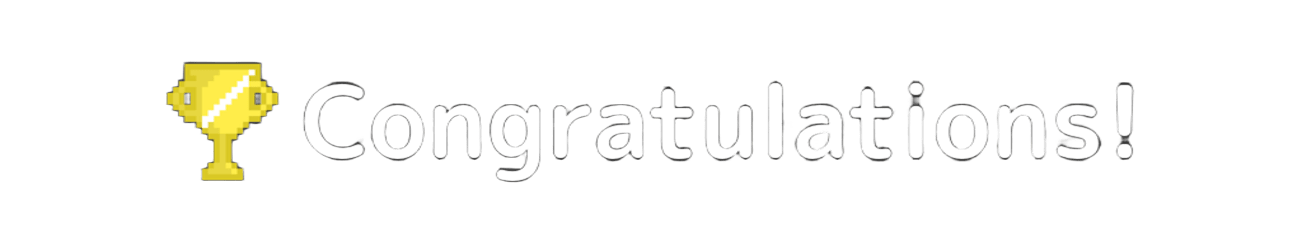